In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_style('darkgrid')
%matplotlib inline

# Gathering Data

In [2]:
url = 'https://en.wikipedia.org/wiki/History_of_Federal_Open_Market_Committee_actions'
html = requests.get(url).content
df_list = pd.read_html(html)
massivechanges = df_list[1]

In [3]:
def getFOMCDates(decade):
    url = f'https://fraser.stlouisfed.org/title/federal-open-market-committee-meeting-minutes-transcripts-documents-677?browse={decade}s'
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')

    dateList = soup.find_all('span', {'class': 'list-item-title'})
    dList = []
    def parseString():
        for i in range(len(dateList)):
            s = dateList[i].text
            ind = s.find('Meeting, ')
            if ind != None and ind != -1:
                dateStr = s[ind+9:]
                dateStr = dateStr[:dateStr.find(',')+6]
                if dateStr.find('-') != -1:
                    dateStr = dateStr[:dateStr.find('-')] + dateStr[dateStr.find(','):]
                dList.append(dateStr)
            
    parseString() 
    return dList

In [4]:
dateList = getFOMCDates(2000) + getFOMCDates(2010) + [getFOMCDates(2020)[0]]

In [5]:
def strToCal(s):
    return datetime.strptime(s, '%B %d, %Y')

In [6]:
dateTimeList = list(map(strToCal, dateList))

In [7]:
dateTimeList

[datetime.datetime(2000, 2, 1, 0, 0),
 datetime.datetime(2000, 3, 21, 0, 0),
 datetime.datetime(2000, 5, 16, 0, 0),
 datetime.datetime(2000, 6, 27, 0, 0),
 datetime.datetime(2000, 8, 22, 0, 0),
 datetime.datetime(2000, 10, 3, 0, 0),
 datetime.datetime(2000, 11, 15, 0, 0),
 datetime.datetime(2000, 12, 19, 0, 0),
 datetime.datetime(2001, 1, 30, 0, 0),
 datetime.datetime(2001, 3, 20, 0, 0),
 datetime.datetime(2001, 5, 15, 0, 0),
 datetime.datetime(2001, 6, 26, 0, 0),
 datetime.datetime(2001, 8, 21, 0, 0),
 datetime.datetime(2001, 10, 2, 0, 0),
 datetime.datetime(2001, 11, 6, 0, 0),
 datetime.datetime(2001, 12, 11, 0, 0),
 datetime.datetime(2002, 1, 29, 0, 0),
 datetime.datetime(2002, 3, 19, 0, 0),
 datetime.datetime(2002, 5, 7, 0, 0),
 datetime.datetime(2002, 6, 25, 0, 0),
 datetime.datetime(2002, 8, 13, 0, 0),
 datetime.datetime(2002, 9, 24, 0, 0),
 datetime.datetime(2002, 11, 6, 0, 0),
 datetime.datetime(2002, 12, 10, 0, 0),
 datetime.datetime(2003, 1, 28, 0, 0),
 datetime.datetime(2003

In [8]:
dfList = []
d = datetime(2002, 12, 10)
for elem in dateTimeList:
    if elem > d:
        dfList.append([None, elem])

In [9]:
df = pd.DataFrame(dfList, columns=['Fed. Funds Rate', 'Converted_Datetime'])

In [10]:
priceoffutures = pd.read_csv('30-day-fed-funds-futures.csv')

# Cleaning & Processing

In [11]:
date_time_str = 'January 29, 2003'
date_time_obj = datetime.strptime(date_time_str, '%B %d, %Y')

In [12]:
date_time_obj

datetime.datetime(2003, 1, 29, 0, 0)

In [13]:
massivechanges['Converted_Datetime'] = massivechanges['Date'].apply(lambda x:datetime.strptime(x, '%B %d, %Y'))

In [14]:
del massivechanges['Votes']
del massivechanges['Date']
del massivechanges['Notes']
del massivechanges['Discount Rate']

In [15]:
massivechanges

,Fed. Funds Rate,Converted_Datetime
0,0%–0.25%,2020-03-15
1,1%–1.25%,2020-03-03
2,1.50%–1.75%,2019-10-30
3,1.75%–2.00%,2019-09-18
4,2.00%–2.25%,2019-07-31
...,...,...
61,1.25%,2003-05-06
62,1.25%,2003-03-18
63,1.25%,2003-01-29
64,1.25%,2003-01-09


In [16]:
massivechanges = massivechanges.append(df, ignore_index=True)

In [17]:
massivechanges.sort_values(by='Converted_Datetime', ascending=False, inplace=True, ignore_index=True)

massivechanges

,Fed. Funds Rate,Converted_Datetime
0,0%–0.25%,2020-03-15
1,1%–1.25%,2020-03-03
2,None,2020-01-28
3,None,2019-12-10
4,1.50%–1.75%,2019-10-30
...,...,...
200,None,2003-03-18
201,1.25%,2003-01-29
202,None,2003-01-28
203,1.25%,2003-01-09


In [18]:
bigChanges = massivechanges.sort_values(by='Converted_Datetime', ignore_index=True)

newDf = pd.DataFrame(columns=['Fed. Funds Rate', ])

for index, row in bigChanges.iterrows():
    if pd.isnull(row['Fed. Funds Rate']):
        if row['Converted_Datetime'] == bigChanges.iloc[index+1, 1] or row['Converted_Datetime'] == bigChanges.iloc[index+1, 1] + timedelta(days=-1):
            continue
        else:
            bigChanges.iloc[index, 0] = bigChanges.iloc[index-1, 0]

bigChanges.dropna(inplace=True)
bigChanges.drop_duplicates(inplace=True, ignore_index=True)
bigChanges

,Fed. Funds Rate,Converted_Datetime
0,1.25%,2002-12-10
1,1.25%,2003-01-09
2,1.25%,2003-01-29
3,1.25%,2003-03-18
4,1.25%,2003-05-06
...,...,...
141,1.50%–1.75%,2019-10-30
142,1.50%–1.75%,2019-12-10
143,1.50%–1.75%,2020-01-28
144,1%–1.25%,2020-03-03


In [19]:
massivechanges = bigChanges.sort_values(by='Converted_Datetime', ascending=False, ignore_index=True)

In [20]:
massivechanges

,Fed. Funds Rate,Converted_Datetime
0,0%–0.25%,2020-03-15
1,1%–1.25%,2020-03-03
2,1.50%–1.75%,2020-01-28
3,1.50%–1.75%,2019-12-10
4,1.50%–1.75%,2019-10-30
...,...,...
141,1.25%,2003-05-06
142,1.25%,2003-03-18
143,1.25%,2003-01-29
144,1.25%,2003-01-09


In [21]:
priceoffutures['Date'] = priceoffutures['date'].apply(lambda x:datetime.strptime(x, '%m/%d/%Y'))

In [22]:
del priceoffutures['date']

In [23]:
def parsestring(s):
    if chr(8211) in s:
        wow = s.split(chr(8211))
        s1 = wow[0][:-1]
        s2 = wow[1][:-1]
        return (float(s1) + float(s2)) / 2
    else:
        return float(s[:-1])

In [24]:
massivechanges['Rate'] = massivechanges['Fed. Funds Rate'].apply(parsestring)

In [25]:
del massivechanges['Fed. Funds Rate']

In [26]:
massivechanges

,Converted_Datetime,Rate
0,2020-03-15,0.125
1,2020-03-03,1.125
2,2020-01-28,1.625
3,2019-12-10,1.625
4,2019-10-30,1.625
...,...,...
141,2003-05-06,1.250
142,2003-03-18,1.250
143,2003-01-29,1.250
144,2003-01-09,1.250


In [27]:
priceoffutures_dict = {}
for i in range(priceoffutures.shape[0]):
    priceoffutures_dict[priceoffutures['Date'][i]] = priceoffutures[' value'][i]

In [28]:
massivechanges['DayofWeek'] = massivechanges['Converted_Datetime'].apply(lambda x : datetime.weekday(x))

In [29]:
priceoffutures


,value,Date
0,91.710,1988-10-03
1,91.710,1988-10-04
2,91.730,1988-10-05
3,91.700,1988-10-06
4,91.780,1988-10-07
...,...,...
8004,99.920,2020-07-23
8005,99.920,2020-07-24
8006,99.925,2020-07-27
8007,99.922,2020-07-28


In [30]:
def rowinpriceoffutures(i):
    for j in range(len(priceoffutures['Date'])):
        if priceoffutures['Date'][j] > i:
            return j-1
    return -1

In [31]:
massivechanges['rowinpriceoffutures'] = massivechanges['Converted_Datetime'].apply(lambda x : rowinpriceoffutures(x))

In [32]:
returnlist = []
for i in range(len(massivechanges['rowinpriceoffutures'])):
    if massivechanges['DayofWeek'][i] == 5 or massivechanges['DayofWeek'][i] == 6:
        returnlist.append(priceoffutures['Date'][massivechanges['rowinpriceoffutures'][i]])
    else:
        returnlist.append(priceoffutures['Date'][massivechanges['rowinpriceoffutures'][i]-1])

massivechanges['Day before'] = pd.Series(returnlist)


In [33]:
returnlist = []
for i in range(len(massivechanges['rowinpriceoffutures'])):
        returnlist.append(priceoffutures['Date'][massivechanges['rowinpriceoffutures'][i]+1])

massivechanges['Day after'] = pd.Series(returnlist)

In [34]:
massivechanges['Ratedaybefore'] = massivechanges['Day before'].apply(lambda x : priceoffutures_dict[x])

In [35]:
massivechanges['Ratedayafter'] = massivechanges['Day after'].apply(lambda x : priceoffutures_dict[x])

In [36]:
massivechanges['difference'] = massivechanges['Ratedayafter'] - massivechanges['Ratedaybefore']

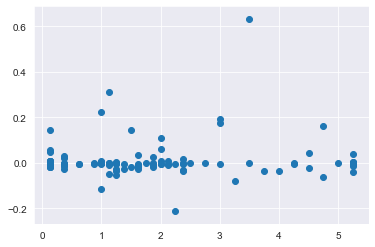

In [37]:
plt.scatter(massivechanges['Rate'], massivechanges['difference'])
plt.show()

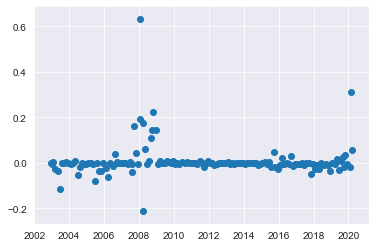

In [38]:
plt.scatter(massivechanges['Converted_Datetime'], massivechanges['difference'])
plt.show()

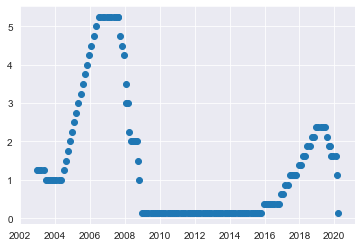

In [39]:
plt.scatter(massivechanges['Converted_Datetime'], massivechanges['Rate'])
plt.show()

In [40]:
returnlist = []
for i in range(len(massivechanges['Rate'])):
    if i == len(massivechanges['Rate'])-1:
        returnlist.append(0)
    else:
        returnlist.append(massivechanges['Rate'][i] - massivechanges['Rate'][i+1])
massivechanges['Rate Changes'] = pd.Series(returnlist)

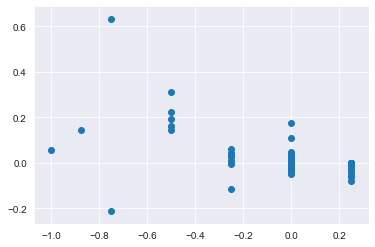

In [41]:
plt.scatter(massivechanges['Rate Changes'], massivechanges['difference'])
plt.show()

In [42]:
massivechanges

,Converted_Datetime,Rate,DayofWeek,rowinpriceoffutures,Day before,Day after,Ratedaybefore,Ratedayafter,difference,Rate Changes
0,2020-03-15,0.125,6,7913,2020-03-13,2020-03-16,99.840,99.8950,0.0550,-1.00
1,2020-03-03,1.125,1,7905,2020-03-02,2020-03-04,98.910,99.2200,0.3100,-0.50
2,2020-01-28,1.625,1,7881,2020-01-27,2020-01-29,98.425,98.4090,-0.0160,0.00
3,2019-12-10,1.625,1,7849,2019-12-09,2019-12-11,98.440,98.4350,-0.0050,0.00
4,2019-10-30,1.625,2,7821,2019-10-29,2019-10-31,98.407,98.4425,0.0355,-0.25
...,...,...,...,...,...,...,...,...,...,...
141,2003-05-06,1.250,1,3671,2003-05-05,2003-05-07,98.825,98.7900,-0.0350,0.00
142,2003-03-18,1.250,1,3637,2003-03-17,2003-03-19,98.830,98.8050,-0.0250,0.00
143,2003-01-29,1.250,2,3604,2003-01-28,2003-01-30,98.780,98.7820,0.0020,0.00
144,2003-01-09,1.250,3,3591,2003-01-08,2003-01-10,98.775,98.7700,-0.0050,0.00


# Figures

## Rate change on difference (before - after)

In [43]:
x = massivechanges['Rate Changes']
y = massivechanges['difference']
xVal, yVal = zip(*sorted((xVal, np.mean([yVal for a, yVal in zip(x, y) if xVal==a])) for xVal in set(x)))

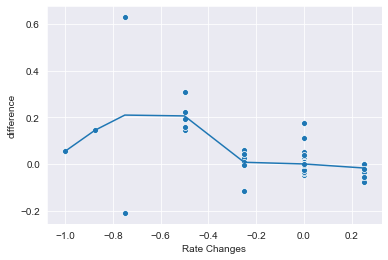

In [44]:
sns.lineplot(x=xVal, y=yVal)
sns.scatterplot(x='Rate Changes', y='difference', data=massivechanges)

In [45]:
x_np = (massivechanges['Rate Changes']).to_numpy()
y_np = massivechanges['difference'].to_numpy()

In [46]:
m, b = np.polyfit(x_np, y_np, 1)

/opt/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/opt/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


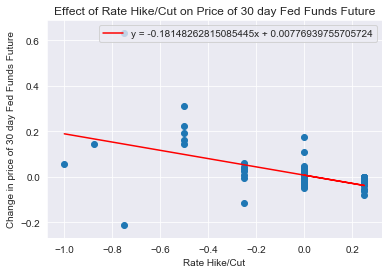

In [47]:
plt.scatter(x, y)
plt.plot(x, m*x + b, 'r-', label = 'y = ' + str(m)+ 'x + ' + str(b))
plt.xlabel("Rate Hike/Cut")
plt.ylabel("Change in price of 30 day Fed Funds Future")
plt.title("Effect of Rate Hike/Cut on Price of 30 day Fed Funds Future")
plt.legend()

plt.savefig('rate_change_on_FFF.png', dpi=800)

In [48]:
massivechanges

,Converted_Datetime,Rate,DayofWeek,rowinpriceoffutures,Day before,Day after,Ratedaybefore,Ratedayafter,difference,Rate Changes
0,2020-03-15,0.125,6,7913,2020-03-13,2020-03-16,99.840,99.8950,0.0550,-1.00
1,2020-03-03,1.125,1,7905,2020-03-02,2020-03-04,98.910,99.2200,0.3100,-0.50
2,2020-01-28,1.625,1,7881,2020-01-27,2020-01-29,98.425,98.4090,-0.0160,0.00
3,2019-12-10,1.625,1,7849,2019-12-09,2019-12-11,98.440,98.4350,-0.0050,0.00
4,2019-10-30,1.625,2,7821,2019-10-29,2019-10-31,98.407,98.4425,0.0355,-0.25
...,...,...,...,...,...,...,...,...,...,...
141,2003-05-06,1.250,1,3671,2003-05-05,2003-05-07,98.825,98.7900,-0.0350,0.00
142,2003-03-18,1.250,1,3637,2003-03-17,2003-03-19,98.830,98.8050,-0.0250,0.00
143,2003-01-29,1.250,2,3604,2003-01-28,2003-01-30,98.780,98.7820,0.0020,0.00
144,2003-01-09,1.250,3,3591,2003-01-08,2003-01-10,98.775,98.7700,-0.0050,0.00


## difference (before - before) on Rate Change

In [49]:
retList = []
for i in range(len(massivechanges['Ratedaybefore'])):
    if i == len(massivechanges['Ratedaybefore'])-1:
        retList.append(0)
    else:
        retList.append(massivechanges['Ratedaybefore'][i+1] - massivechanges['Ratedaybefore'][i])
massivechanges['difference type 2'] = pd.Series(retList)

In [50]:
massivechanges

,Converted_Datetime,Rate,DayofWeek,rowinpriceoffutures,Day before,Day after,Ratedaybefore,Ratedayafter,difference,Rate Changes,difference type 2
0,2020-03-15,0.125,6,7913,2020-03-13,2020-03-16,99.840,99.8950,0.0550,-1.00,-0.930
1,2020-03-03,1.125,1,7905,2020-03-02,2020-03-04,98.910,99.2200,0.3100,-0.50,-0.485
2,2020-01-28,1.625,1,7881,2020-01-27,2020-01-29,98.425,98.4090,-0.0160,0.00,0.015
3,2019-12-10,1.625,1,7849,2019-12-09,2019-12-11,98.440,98.4350,-0.0050,0.00,-0.033
4,2019-10-30,1.625,2,7821,2019-10-29,2019-10-31,98.407,98.4425,0.0355,-0.25,-0.047
...,...,...,...,...,...,...,...,...,...,...,...
141,2003-05-06,1.250,1,3671,2003-05-05,2003-05-07,98.825,98.7900,-0.0350,0.00,0.005
142,2003-03-18,1.250,1,3637,2003-03-17,2003-03-19,98.830,98.8050,-0.0250,0.00,-0.050
143,2003-01-29,1.250,2,3604,2003-01-28,2003-01-30,98.780,98.7820,0.0020,0.00,-0.005
144,2003-01-09,1.250,3,3591,2003-01-08,2003-01-10,98.775,98.7700,-0.0050,0.00,-0.010


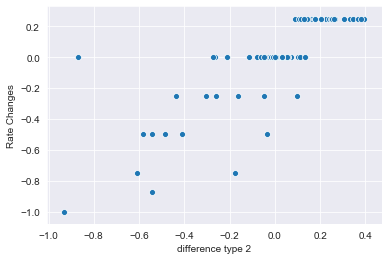

In [51]:
sns.scatterplot(x='difference type 2', y='Rate Changes', data=massivechanges)

In [52]:
x_np = (massivechanges['difference type 2']).to_numpy()
y_np = massivechanges['Rate Changes'].to_numpy()

In [53]:
m, b = np.polyfit(x_np, y_np, 1)

/opt/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/opt/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


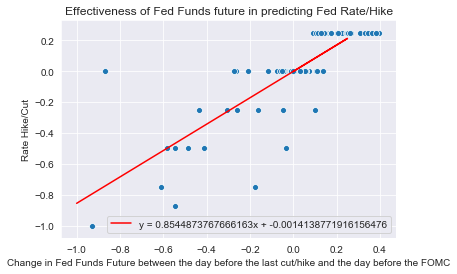

In [54]:
sns.scatterplot(x='difference type 2', y='Rate Changes', data=massivechanges)
plt.plot(x, m*x + b, 'r-', label = 'y = ' + str(m)+ 'x + ' + str(b))
plt.xlabel("Change in Fed Funds Future between the day before the last cut/hike and the day before the FOMC")
plt.ylabel("Rate Hike/Cut")
plt.title("Effectiveness of Fed Funds future in predicting Fed Rate/Hike")
plt.legend()

plt.savefig('FFF_on_rate_change.png', dpi=800)

In [55]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x_np, y_np)
print(slope)
print(intercept)
print(r_value ** 2)
print(p_value)

0.854487376766616
-0.001413877191615653
0.6635572131965038
7.033606424012806e-36


## Rate change on difference (after - after)

In [56]:
retList = []
for i in range(len(massivechanges['Ratedayafter'])):
    if i == len(massivechanges['Ratedayafter'])-1:
        retList.append(0)
    else:
        retList.append(massivechanges['Ratedayafter'][i+1] - massivechanges['Ratedayafter'][i])
massivechanges['difference type 3'] = pd.Series(retList)

In [57]:
massivechanges

,Converted_Datetime,Rate,DayofWeek,rowinpriceoffutures,Day before,Day after,Ratedaybefore,Ratedayafter,difference,Rate Changes,difference type 2,difference type 3
0,2020-03-15,0.125,6,7913,2020-03-13,2020-03-16,99.840,99.8950,0.0550,-1.00,-0.930,-0.6750
1,2020-03-03,1.125,1,7905,2020-03-02,2020-03-04,98.910,99.2200,0.3100,-0.50,-0.485,-0.8110
2,2020-01-28,1.625,1,7881,2020-01-27,2020-01-29,98.425,98.4090,-0.0160,0.00,0.015,0.0260
3,2019-12-10,1.625,1,7849,2019-12-09,2019-12-11,98.440,98.4350,-0.0050,0.00,-0.033,0.0075
4,2019-10-30,1.625,2,7821,2019-10-29,2019-10-31,98.407,98.4425,0.0355,-0.25,-0.047,-0.1025
...,...,...,...,...,...,...,...,...,...,...,...,...
141,2003-05-06,1.250,1,3671,2003-05-05,2003-05-07,98.825,98.7900,-0.0350,0.00,0.005,0.0150
142,2003-03-18,1.250,1,3637,2003-03-17,2003-03-19,98.830,98.8050,-0.0250,0.00,-0.050,-0.0230
143,2003-01-29,1.250,2,3604,2003-01-28,2003-01-30,98.780,98.7820,0.0020,0.00,-0.005,-0.0120
144,2003-01-09,1.250,3,3591,2003-01-08,2003-01-10,98.775,98.7700,-0.0050,0.00,-0.010,-0.0050


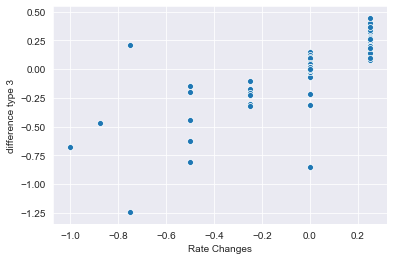

In [58]:
sns.scatterplot(x='Rate Changes', y='difference type 3', data=massivechanges)

In [59]:
x_np = massivechanges['Rate Changes'].to_numpy()
y_np = (massivechanges['difference type 3']).to_numpy()

In [60]:
m, b = np.polyfit(x_np, y_np, 1)

/opt/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/opt/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


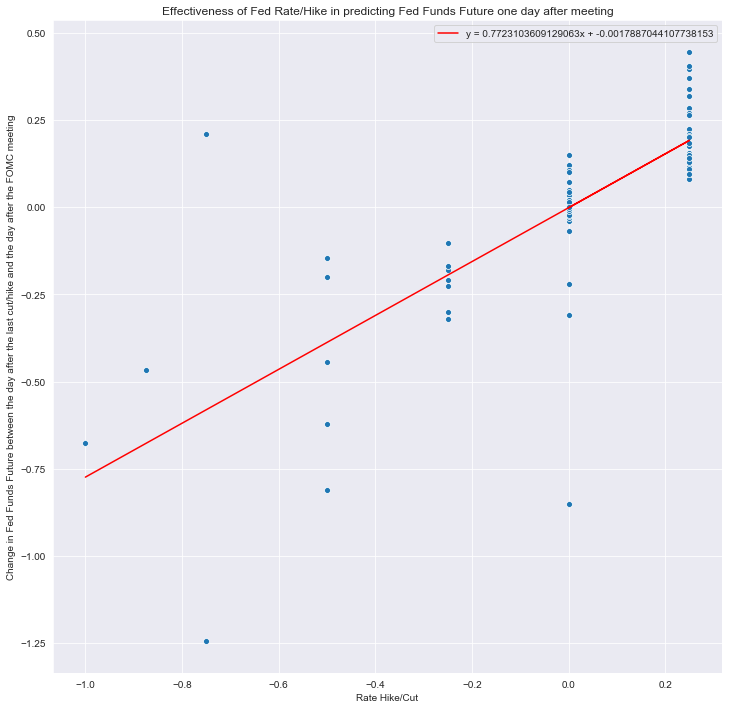

In [61]:
fig = plt.figure(figsize=(12, 12))

sns.scatterplot(x='Rate Changes', y='difference type 3', data=massivechanges)
plt.plot(x, m*x + b, 'r-', label = 'y = ' + str(m)+ 'x + ' + str(b))
plt.ylabel("Change in Fed Funds Future between the day after the last cut/hike and the day after the FOMC meeting")
plt.xlabel("Rate Hike/Cut")
plt.title("Effectiveness of Fed Rate/Hike in predicting Fed Funds Future one day after meeting")
plt.legend()

# plt.savefig('rate_change_on_FFF_2.png', dpi=800)

In [62]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x_np, y_np)
print(slope)
print(intercept)
print(r_value ** 2)
print(p_value)

0.7723103609129075
-0.0017887044107737981
0.5645045838882956
8.927373939095176e-28
